In [1]:
import chess
import chess.pgn

In [2]:
import os
from IPython.display import display, clear_output
import time

In [3]:
class ChessMove:
    cur_board_state = None
    
    def __init__(self, fen, uci):
        self.pre_board_state = fen
        self.uci_notation = uci
        self.chessdotMove = chess.Move.from_uci(uci)
        self.chessdotBoard = chess.Board(fen=self.pre_board_state)
        if ChessMove.cur_board_state is None:
            ChessMove.cur_board_state = fen
        self.apply_move()

        #Piece Characteristics
        self.start_square = self.chessdotMove.from_square
        self.end_square = self.chessdotMove.to_square
        self.distance = chess.square_distance(self.start_square, self.end_square)
        self.piece = self.chessdotBoard.piece_at(self.start_square)
        self.piece_value = self.piece.piece_type
        self.color = self.piece.color
        
        
        #Move Characteristics
        self.is_check = self.chessdotBoard.gives_check(self.chessdotMove)
        check_set = chess.Board(ChessMove.cur_board_state).checkers().tolist()
        self.is_double_check = sum(check_set) > 1 and self.is_check
        self.is_discovered_check = self.is_check and (not check_set[self.end_square] or self.is_double_check)

        self.is_capture = self.chessdotBoard.is_capture(self.chessdotMove)
        self.captured_piece = self.chessdotBoard.piece_at(self.end_square)

        self.threats = self.get_prepare_capture()
        self.is_threat = len(self.threats) > 0
        
        self.is_developing = self.get_relative_position(self.start_square, self.end_square) > 0
        self.is_retreating = self.get_relative_position(self.start_square, self.end_square) < 0

        
        #Move Interactions
        self.was_hanging = self.get_hanging_status(self.chessdotBoard, self.start_square, not self.color)
        self.is_hanging = self.get_hanging_status(self.apply_move(), self.end_square, not self.color)
        self.was_true_hanging = self.get_hanging_status(self.chessdotBoard, self.start_square, not self.color, True)
        self.is_true_hanging = self.get_hanging_status(self.apply_move(), self.end_square, not self.color, True)
        self.create_tension = self.get_prepare_capture('tension')
        self.resolve_tension = self.get_tension_change('resolve')
        self.maintain_tension = self.get_tension_change('maintain')
        

    def apply_move(self):
        board = chess.Board(fen=self.pre_board_state)
        board.push(self.chessdotMove)
        ChessMove.cur_board_state = board.fen()
        return board

    def get_square_attackers(self, board, square, color):
        return {sq: board.piece_at(sq).piece_type for sq in board.attackers(color, square)}

    def get_relative_position(self, sq_start, sq_end):
        return (chess.square_rank(sq_start) - chess.square_rank(sq_end)) * (-1)**int(self.color)
    
    def get_prepare_capture(self, toret='attack'):
        board = self.apply_move()
        board.push(chess.Move.null())
        attacked_squares={}
        tension_squares={}
        for sq in board.attacks(self.end_square):
            if board.piece_at(sq) != None:
                if board.piece_at(sq).color == self.color:
                    continue
                target_value = board.piece_at(sq).piece_type
                attack_dict = self.get_square_attackers(board, sq, self.color)
                defend_dict = self.get_square_attackers(board, sq, not self.color)
                attackers = sorted([attack_dict[sq] for sq in attack_dict])
                defenders = sorted([defend_dict[sq] for sq in defend_dict])
                if attackers[0] < target_value or (attackers[0] == target_value and len(attackers) > len(defenders)) or len(defenders) == 0:
                    attacked_squares[sq] = target_value
                elif len(attackers) > len(defenders) or (attackers[0] < 5 and target_value > 1) or attackers[0] == 1:
                    tension_squares[sq] = target_value
        if toret == 'attack':
            return sorted(attacked_squares, key=lambda s: attacked_squares[s], reverse=True)
        elif toret == 'tension':
            return sorted(tension_squares, key=lambda s: tension_squares[s], reverse=True)

    def get_hanging_status(self, board, square, color, true=False):
        attackers = self.get_square_attackers(board, square, color)
        defenders = self.get_square_attackers(board, square, not color)
        legal_attackers = self.get_legal_from_dict(board, square, attackers)
        if true:
            attackers = legal_attackers
        if attackers == {}:
            return False
        if sorted([attackers[sq] for sq in attackers])[0] < self.piece_value:
            return True
        elif len(attackers) > len(defenders):
            return True
        else:
            return False

    def get_legal_from_dict(self, board, square, sq_dict):
        board.turn = not self.color
        target = self.square_ind_to_name(square)
        moves = [self.square_ind_to_name(sq) + target for sq in sq_dict]
        mask = [board.is_legal(chess.Move.from_uci(move)) for move in moves]
        legal_sq_dict = {}
        for key, include in zip(sq_dict.keys(), mask):
            if include:
                legal_sq_dict[key] = sq_dict[key]
        return legal_sq_dict
        
    def get_tension_change(self, toret):
        def cap_relevant(move, board):
            capper = board.piece_at(move.from_square).piece_type
            capped = board.piece_at(move.to_square).piece_type
            test_board = chess.Board(board.fen())
            test_board.push(move)
            if capper == 1:
                return True
            if self.get_hanging_status(test_board, move.to_square, board.turn):
                return capped > 1
            return False
        board = chess.Board(fen=self.pre_board_state)
        pre_captures = [move for move in board.legal_moves if board.is_capture(move)]
        pre_mask = [cap_relevant(move, board) for move in pre_captures]
        pre_captures = [move.to_square for move, include in zip(pre_captures, pre_mask) if include]
        board.push(self.chessdotMove)
        board.push(chess.Move.null())
        post_captures = [move for move in board.legal_moves if board.is_capture(move)]
        post_mask = [cap_relevant(move, board) for move in post_captures]
        post_captures = [move.to_square for move, include in zip(post_captures, post_mask) if include]
        created_squares = [sq for sq in post_captures if sq not in pre_captures]
        released_squares = [sq for sq in pre_captures if sq not in post_captures]
        maintained_squares = [sq for sq in pre_captures if sq in post_captures]
        tension_squares = {
            'create': created_squares, #this includes tension plus attack
            'maintain': maintained_squares,
            'resolve': released_squares
        }
        return tension_squares[toret]
        
    def square_ind_to_name(self, square_ind):
        return chess.square_name(square_ind)

In [4]:
#r2qk2r/1p1nbpp1/5n1p/3NNb2/8/P6P/BPP2PP1/3QR1K1 w kq - 5 14
#create resolve tension

amove = ChessMove('rnbqkbnr/ppp3pp/3p1p2/4p3/1P1P4/P7/2P1PPPP/RNBQKBNR w KQkq - 0 4', 'g1f3')
#amove = ChessMove('rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2', 'c7c5')
amove.threats, amove.create_tension, amove.resolve_tension, amove.maintain_tension
#amove = ChessMove(amove.cur_board_state, 'd5d6')
#d=amove.resolve_tension

([], [36], [], [36])

In [5]:
def load_pgns(file_path, num_games=None, start_index=0):
    games = []
    with open(file_path, "r") as file:
        for _ in range(start_index):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in range(num_games) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

In [6]:
assets_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'test_asset')
single_path = os.path.join(assets_path, 'game_52.pgn')
games = load_pgns(single_path)
game = games[0]

In [7]:
def animate_game(game, animate=True):
    moves = [x.uci() for x in game.mainline_moves()]
    rows = [] 
    board.reset()
    for move in moves:
        row = {}
        row['move'] = move
        board.push_uci(move)
        row['fen'] = board.fen()
        rows.append(row)
        if animate:
            time.sleep(.3)
            clear_output(wait=True)
            display(board)
    return rows

In [8]:
game.headers

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/HmYBgXC1', Site='https://lichess.org/ufqUImzs', Date='????.??.??', Round='?', White='Lexman661', Black='aspekt', Result='0-1', BlackElo='1952', BlackRatingDiff='+12', ECO='A01', Opening='Nimzo-Larsen Attack: Modern Variation #2', Termination='Normal', TimeControl='300+0', UTCDate='2017.04.30', UTCTime='22:00:01', WhiteElo='1950', WhiteRatingDiff='-11')

In [9]:
node = game
node.move

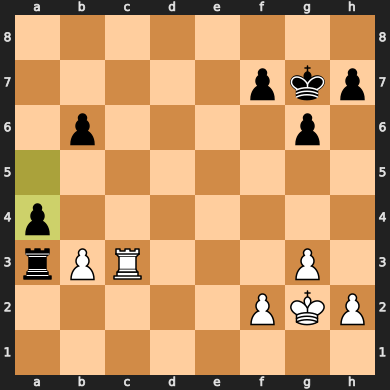

[{'move': 'b2b3',
  'fen': 'rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'},
 {'move': 'e7e5',
  'fen': 'rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq - 0 2'},
 {'move': 'c1b2',
  'fen': 'rnbqkbnr/pppp1ppp/8/4p3/8/1P6/PBPPPPPP/RN1QKBNR b KQkq - 1 2'},
 {'move': 'd7d6',
  'fen': 'rnbqkbnr/ppp2ppp/3p4/4p3/8/1P6/PBPPPPPP/RN1QKBNR w KQkq - 0 3'},
 {'move': 'g2g3',
  'fen': 'rnbqkbnr/ppp2ppp/3p4/4p3/8/1P4P1/PBPPPP1P/RN1QKBNR b KQkq - 0 3'},
 {'move': 'g8f6',
  'fen': 'rnbqkb1r/ppp2ppp/3p1n2/4p3/8/1P4P1/PBPPPP1P/RN1QKBNR w KQkq - 1 4'},
 {'move': 'f1g2',
  'fen': 'rnbqkb1r/ppp2ppp/3p1n2/4p3/8/1P4P1/PBPPPPBP/RN1QK1NR b KQkq - 2 4'},
 {'move': 'g7g6',
  'fen': 'rnbqkb1r/ppp2p1p/3p1np1/4p3/8/1P4P1/PBPPPPBP/RN1QK1NR w KQkq - 0 5'},
 {'move': 'd2d3',
  'fen': 'rnbqkb1r/ppp2p1p/3p1np1/4p3/8/1P1P2P1/PBP1PPBP/RN1QK1NR b KQkq - 0 5'},
 {'move': 'f8g7',
  'fen': 'rnbqk2r/ppp2pbp/3p1np1/4p3/8/1P1P2P1/PBP1PPBP/RN1QK1NR w KQkq - 1 6'},
 {'move': 'c2c4',
  'fen': 'rnbqk2r/ppp2pbp/3p1

In [10]:
board = chess.Board()
animate_game(game)

In [11]:
#The Move Metadata
#move_time_spent
#move_time_left
#increment_next_move
#opponent_time_left

#player_id
#player_rating
#opponent_rating
#move quality (eval)
#pre-move gamestate
